# OBIS full export and gridded product

OBIS also produces a full export, containing all occurrence data from OBIS packed in a single Parquet file, and a gridded product (`speciesgrids`) for very efficient queries. We will learn more about each of those in this notebook.

Here we will use **R**, but all the operations can also be done through **Python**. For the `speciesgrids`, some examples with Python are available in this [repo](https://github.com/iobis/speciesgrids/tree/main/notebooks).

----

Hands-on outline:

1. A brief introduction to Parquet 
2. Full export 
3. Gridded product 

Before starting, we need to install a few packages on Google Colab (if you are using Binder, just skip this cell). Also, if you are coming from the previous notebook and already installed the packages, you don't need to do it again.

In [ ]:
# On your local computer you can use install.packages() for everything
# Here we use the system interface to some, as the installation
# with r2u is faster.
system("apt-get install r-cran-sf r-cran-terra") # Spatial packages
system("apt-get install r-cran-robis")           # OBIS API interface
system("apt-get install r-cran-arrow")           # To deal with full export
system("apt-get install r-cran-DBI")             # To deal with full export
system("apt-get install r-cran-duckdb")          # To deal with full export
system("apt-get install r-cran-rnaturalearth")   # For mapping
system("apt-get install r-cran-h3jsr")           # For indexing (H3 sytem)

# Install additional from GitHub
system("apt-get install r-cran-bspm")
bspm::enable()
devtools::install_github("iobis/obistools")
devtools::install_github("ropensci/mregions2")

We also need to download some sample data.

In [ ]:
# Install AWS CLI interface, to get speciesgrids if not done
system('curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"')
system('unzip awscliv2.zip')
system('sudo ./aws/install')
system('rm awscliv2.zip')
system('rm -r aws')

In [ ]:
# Download some data that we will be using in this practical
#### Download species grids
fs::dir_create("speciesgrids")
system("aws s3 cp --recursive s3://obis-products/speciesgrids/h3_7 speciesgrids --no-sign-request")

#### Download full export sample
system("aws s3 cp s3://obis-shared/training/full_export_reduced.parquet . --no-sign-request")

#### Download copernicus data sample
system("aws s3 cp s3://obis-shared/training/glorys_sample.tif . --no-sign-request")

### 1. A brief introduction to Parquet

This content comes from an OBIS tutorial that you can find here: [https://resources.obis.org/tutorials/arrow-obis/](https://resources.obis.org/tutorials/arrow-obis/)

#### What is Parquet

Parquet is a lightweight format designed for columnar storage. Its main
difference when compared to other formats like **csv** is that Parquet
is column-oriented (while csv is row-oriented). This means that Parquet
is much more efficient for data accessing.To illustrate, consider the
scenario of extracting data from a specific column in a CSV file. This
operation entails reading through all rows across all columns. In
contrast, Parquet enables selective access solely to the required
column, minimizing unnecessary data retrieval. Also very important:
Parquet files are several times lighter than csv files, improving
storage and sharing of data. You can learn more about Parquet
[here](https://parquet.apache.org/).

<img src="https://resources.obis.org/tutorials/arrow-obis/image1.jpg" width=600></img>

The `Arrow` package enable to work with Parquet files (as well some
other interesting formats) within R. You can read the full documentation
of the package [here](https://arrow.apache.org/docs/r/index.html).

### 2. Full export

Sometimes you need to do analyses using big chunks of OBIS data. In those cases, downloading it through the API is not practical. OBIS also offer the full export of all OBIS occurrence data in `parquet` or `csv` formats.

<span style="color: #e36400">NOTE: the `csv` format will be deprecated in the future.</span>

You can download the full export here (~15GB): https://obis.org/data/access/

We will work with the `parquet` file. Loading all this data at once in your computer is usually impractical (or impossible), as it will not fit in memory. But that is not a problem! Arrow offer us many ways of loading just the structure of the file and perform filters without loading the dataset in memory. Let's explore how to do that.

To save time, we downloaded a smaller version of the full export that contains just a part of the data.

In [ ]:
library(arrow)
library(dplyr)
library(ggplot2)

ds_path <- "full_export_reduced.parquet"

ds <- open_dataset(ds_path)

ds

We call `arrow::open_dataset` to open a file (or a folder with multiple files) without loading it into memory. Note that you can just see the columns and data types.

As a first example, we will select only the columns `scientificName`, `family`, and `date_year`. Then, we will filter by the family **Pomacentridae**. Finally, we will group by `scientificName` and `date_year` and count the number of records:

In [ ]:
pomac_records <- ds |> 
    select(scientificName, family, date_year) |> 
    filter(family == "Pomacentridae") |> 
    group_by(scientificName, date_year) |> 
    count() |> 
    collect()

head(pomac_records)

You probably noticed that at the end of our `dplyr` query we added the function **`collect()`**. This is essential! It is just at this point that `arrow` will process your request.

Ok, now let's get the records for the "Nemo"s species, and plot in a map.

In [ ]:
sp_nemos <- robis::checklist("Amphiprion")

sp_nemos <- sp_nemos[sp_nemos$taxonRank == "Species",]

sp_nemo_top4 <- sp_nemos[order(sp_nemos$records, decreasing = T), ][1:4,]

nemo_data <- ds |> 
    select(scientificName, decimalLongitude, decimalLatitude) |> 
    filter(scientificName %in% sp_nemo_top4$scientificName) |> 
    collect()

wrld <- rnaturalearth::ne_countries(returnclass = "sf")

ggplot(nemo_data) +
    geom_sf(data = wrld) +
    geom_point(aes(x = decimalLongitude, y = decimalLatitude, color = scientificName)) +
    facet_wrap(~ scientificName) +
    theme_light()


Although this works fine, for big queries it can be a bit slow, even if the file is local. Another approach that is very good is [`duckDB`](https://duckdb.org/docs/api/r.html). It not only enable to do the same queries, using SQL, but it also have a [spatial extension.](https://duckdb.org/docs/extensions/spatial/functions)

In [ ]:
library(DBI)
library(duckdb)
library(glue)

con <- dbConnect(duckdb())
dbSendQuery(con, "install spatial; load spatial;")
dbSendQuery(con, "install httpfs; load httpfs;")

query <- glue(
    "
    select scientificName, count(*) as number_records
    from read_parquet('{ds_path}')
    where family = 'Pomacentridae'
    group by scientificName
    "
)

pom_fam <- dbGetQuery(con, query)

pom_fam

And for spatial queries is also straightforward. We just need to read the longitude and latitude as Spatial points and then use ST_Intersects to intersect with our geometry (the WKT).

In [ ]:

# And for the case of an area is much faster because it supports spatial queries!
wkt_area <- "POLYGON ((-79.189453 27.293689, -79.584961 23.765237, -75.9375 22.43134, -73.959961 24.726875, -74.750977 27.176469, -79.189453 27.293689))"

query <- glue::glue(
    "
  select distinct scientificName
  from read_parquet('{ds_path}')
  where ST_Intersects(ST_Point(decimalLongitude, decimalLatitude), ST_GeomFromText('{wkt_area}'))
  "
)

all_sps_area <- dbGetQuery(con, query)

head(all_sps_area)

### 3. `speciesgrids` product

A recent addition to OBIS is the `speciesgrids` product. [`speciesgrids`](https://github.com/iobis/speciesgrids) is a Python package to build WoRMS aligned combined OBIS and GBIF species distribution datasets. The resulting dataset is available in a few resolutions on AWS S3. The dataset can be downloaded locally for best performance, or queried directly from the S3 bucket. For more details about downloading and using the dataset, see the [speciesgrids README](https://github.com/iobis/speciesgrids). The dataset is served as a `parquet` file.

The product aggregate all marine data from the two major databases, in a very fine grid using Uber's H3 system. H3 is an hierarchical grid system, and that enables both very fast queries and aggregations. To learn more about Uber's H3 system check [here.](https://h3geo.org/)

<img src="https://h3geo.org/images/parent-child.png" height=200></img>

We already downloaded a local version, and we will work with that. If you instead wanted to work with the remote version you would use:

```
ds_path <- "s3://obis-products/speciesgrids/h3_7"
ds <- open_dataset(ds_path)
```

In [ ]:
ds_path <- "speciesgrids/h3_7"

ds <- open_dataset(ds_path)

ds

Let's get all records for the genus **Amphiprion**, which holds the "Nemo's".

<img src="https://upload.wikimedia.org/wikipedia/commons/a/a7/Peces_payaso_%28Amphiprion_bicinctus%29_en_una_an%C3%A9mona_burbuja_%28Entacmaea_quadricolor%29%2C_mar_Rojo%2C_Egipto%2C_2023-04-14%2C_DD_36.jpg" width=300><br><span style="font-size: xx-small">Photo by: Diego Delso (CC-BY-SA) from Wikimedia (https://upload.wikimedia.org/wikipedia/commons/a/a7/Peces_payaso_%28Amphiprion_bicinctus%29_en_una_an%C3%A9mona_burbuja_%28Entacmaea_quadricolor%29%2C_mar_Rojo%2C_Egipto%2C_2023-04-14%2C_DD_36.jpg)</span></img>

In [ ]:
amph_records <- ds |> 
    filter(genus == "Amphiprion") |> 
    collect()

nrow(amph_records)

head(amph_records[,c("species", "genus", "cell", "records", "min_year", "max_year")])

We can aggregate the data by H3 cell, to get for example the total number of species by cell.

In [ ]:
amph_total_cell <- amph_records |> 
    group_by(cell) |> 
    count()

head(amph_total_cell)

We can use this data to calculate the [realized] thermal ranges of those species. For that, we will use an SST layer with the average SST of the period 2020-2021 from the [GLORYS12V1 product](https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/description).

In this case, we don't need to use just the records from this period, but it would be interesting to avoid using records that are from years to far from the data. We will filter our records to be between 2010 and 2024. We will also keep only species with individual counts higher than 30 records.

In [ ]:
amph_filt <- amph_records |> 
    filter(min_year >= 2010 & max_year <= 2024)

sp_count <- amph_filt |> 
    group_by(species) |> 
    count() |> 
    filter(n >= 30)

amph_filt <- amph_filt |> 
    filter(species %in% sp_count$species)

length(unique(amph_filt$species))

The `speciesgrids` already contains a `geometry` column. So, let's transform this  a `sf` object using `sf::st_as_sf()` and `sf::st_as_sfc()`.

In [26]:
coords <- sf::st_as_sf(sf::st_as_sfc(amph_filt$geometry), crs = "EPSG:4326")

amph_filt_sf <- cbind(coords, amph_filt)
print(amph_filt_sf)

Simple feature collection with 5107 features and 16 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -179.9034 ymin: -33.88877 xmax: 179.9825 ymax: 53.86259
Geodetic CRS:  WGS 84
First 10 features:
                   species AphiaID records min_year max_year source_obis
1       Amphiprion percula  278402       1     2015     2015       FALSE
2  Amphiprion chrysopterus  278393      16     2010     2015        TRUE
3  Amphiprion chrysopterus  278393       4     2010     2010        TRUE
4   Amphiprion perideraion  278403      16     2015     2015        TRUE
5  Amphiprion chrysopterus  278393       4     2010     2010        TRUE
6   Amphiprion perideraion  278403       2     2018     2018        TRUE
7  Amphiprion chrysopterus  278393      10     2010     2010        TRUE
8  Amphiprion chrysopterus  278393       2     2013     2013        TRUE
9     Amphiprion bicinctus  212778       1     2018     2018       FALSE
10    Amphiprion bicinctus  212778       1     2023   

Now we can extract the SST information.

terra 1.7.71


Attaching package: 'terra'


The following object is masked from 'package:arrow':

    buffer


Warning message:
"[is.lonlat] coordinates are out of range for lon/lat"


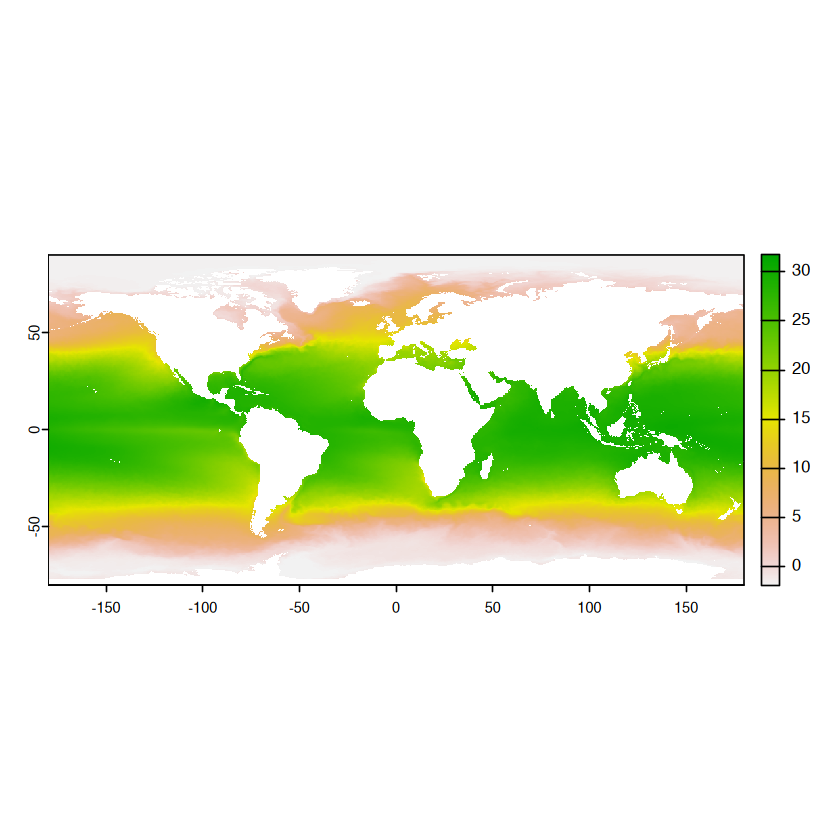

In [24]:
library(terra)

sst <- rast("../../glorys_sample.tif")

plot(sst)

Error in as.character(d[[i]]) : 
  Can't convert `x` <arrow_binary> to <character>.


,mean,species
,<dbl>,<chr>
1,6.304183,Amphiprion percula
2,28.057438,Amphiprion chrysopterus
3,28.049831,Amphiprion chrysopterus
4,28.057438,Amphiprion perideraion
5,28.118401,Amphiprion chrysopterus
6,28.135416,Amphiprion perideraion


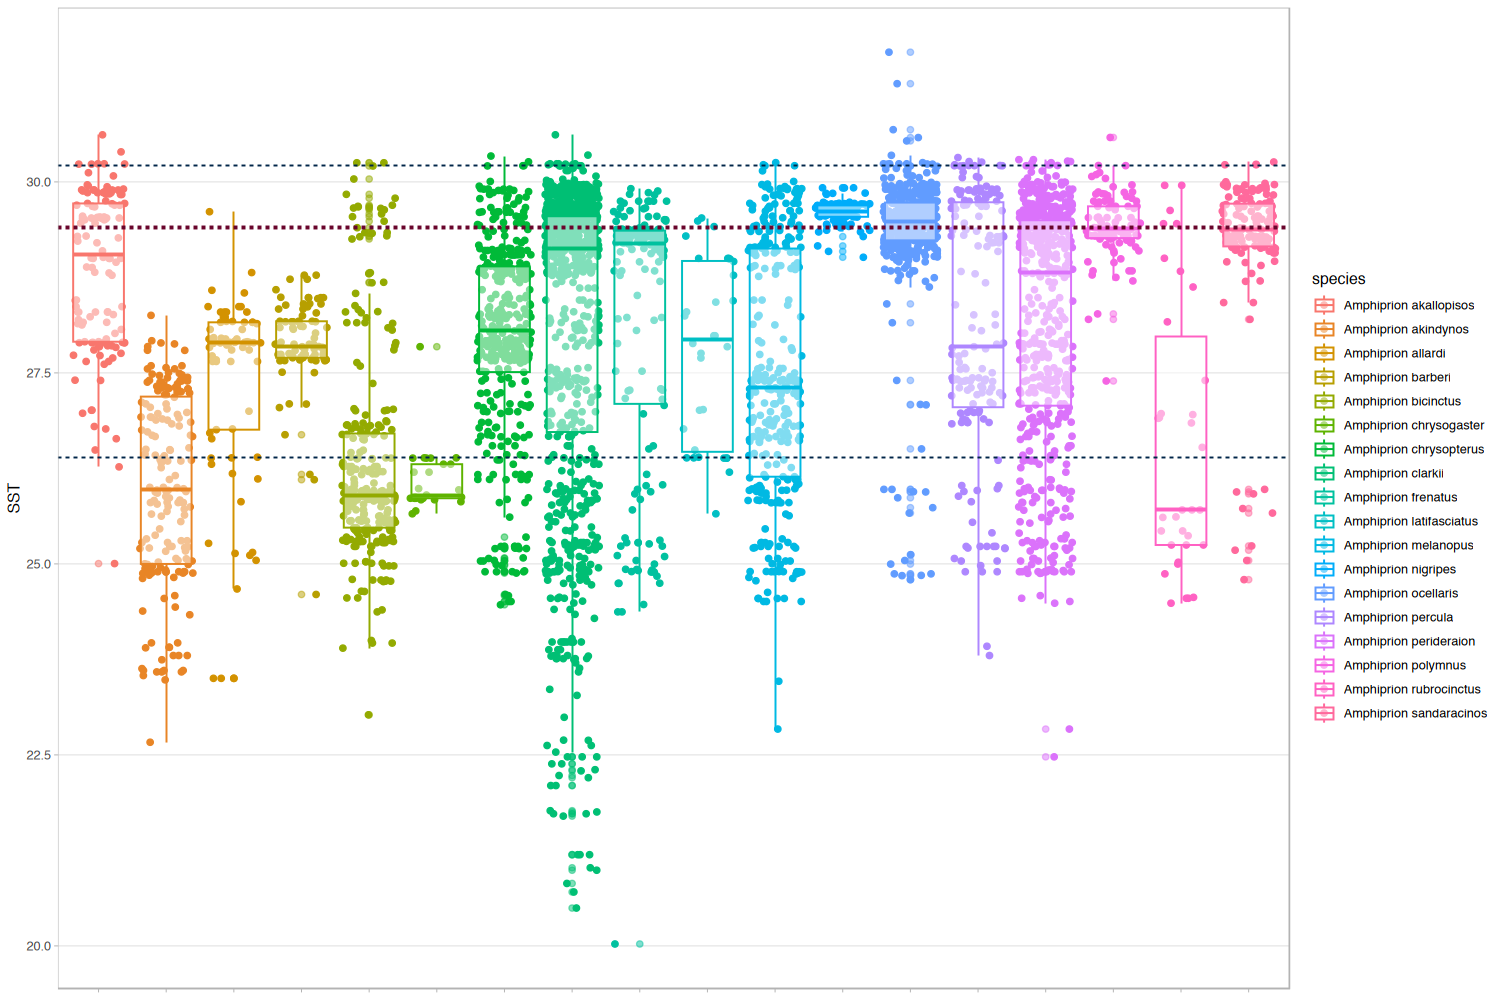

In [48]:
options(repr.plot.width = 15, repr.plot.height = 10)
extracted_sst <- terra::extract(sst, amph_filt_sf, ID = FALSE)

extracted_sst$species <- amph_filt_sf$species
head(extracted_sst)

extracted_sst <- extracted_sst[!is.na(extracted_sst$mean),]

# Remove a strange outlier
extracted_sst <- extracted_sst[extracted_sst$mean > 10,]

sp_limits <- extracted_sst |> 
    group_by(species) |> 
    summarise(lim = quantile(mean, .95))

ggplot(extracted_sst, aes(x = species, y = mean, color = species)) +
    geom_jitter() +
    geom_boxplot(alpha = .5) +
    geom_hline(yintercept = min(sp_limits$lim), color = "#002548", linetype = 2) +
    geom_hline(yintercept = max(sp_limits$lim), color = "#002548", linetype = 2) +
    geom_hline(yintercept = mean(sp_limits$lim), color = "#69052c", linetype = 2, linewidth = 1) +
    theme_light() +
    xlab(NULL) + ylab("SST") +
    theme(panel.grid.major.x = element_blank(),
    panel.grid.minor.y = element_blank(),
    axis.text.x = element_blank())

#### Aggregations

Because H3 system is hierarchical, we can actually aggregate it to coarser cells.

In [ ]:
amph_h3_4 <- amph_records |> 
    mutate(h3_4 = h3jsr::get_parent(cell, res = 4))
head(amph_h3_4)

And calculate and plot the number of records, for example.

In [ ]:
amph_h3_4_agg <- amph_h3_4 |> 
    group_by(h3_4) |> 
    summarise(total_records = sum(records))

amph_h3_4_agg_sf <- h3jsr::cell_to_polygon(amph_h3_4_agg$h3_4, simple = FALSE)

print(amph_h3_4_agg_sf)

colnames(amph_h3_4_agg)[1] <- "h3_address"

amph_h3_4_agg <- left_join(amph_h3_4_agg_sf, amph_h3_4_agg)

wrld <- rnaturalearth::ne_countries(returnclass = "sf")

ggplot() +
    geom_sf(data = wrld) +
    geom_sf(data = amph_h3_4_agg, aes(fill = total_records)) +
    theme_light() +
    coord_sf(xlim = c(150, 170), ylim = c(-40, -30))


We can do the same operations that we did with the **full export** using `DuckDB` with this dataset. In our experience, `DuckDB` performance is much better.